In [403]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])


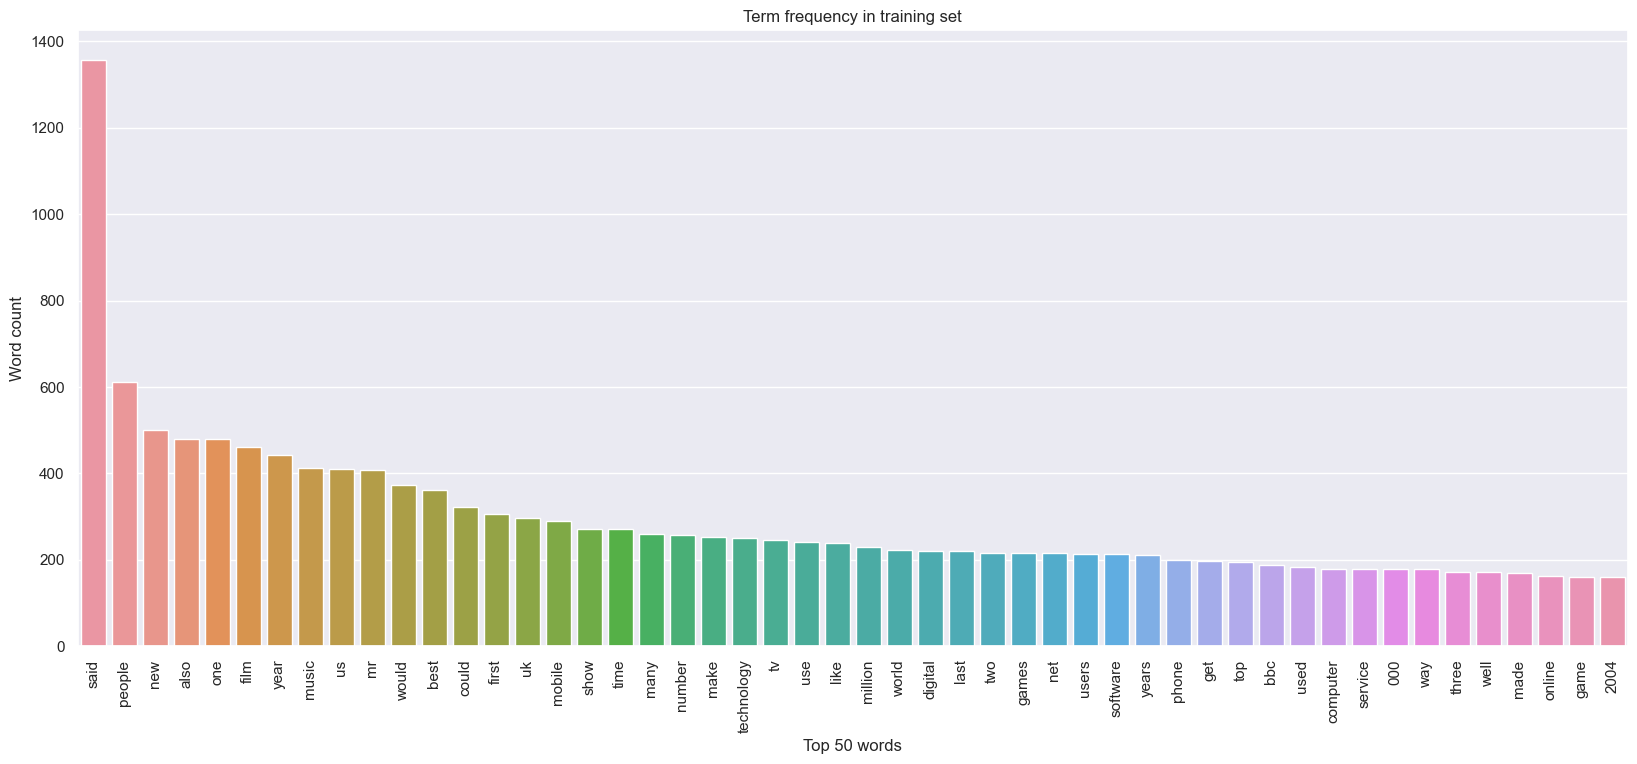

In [75]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

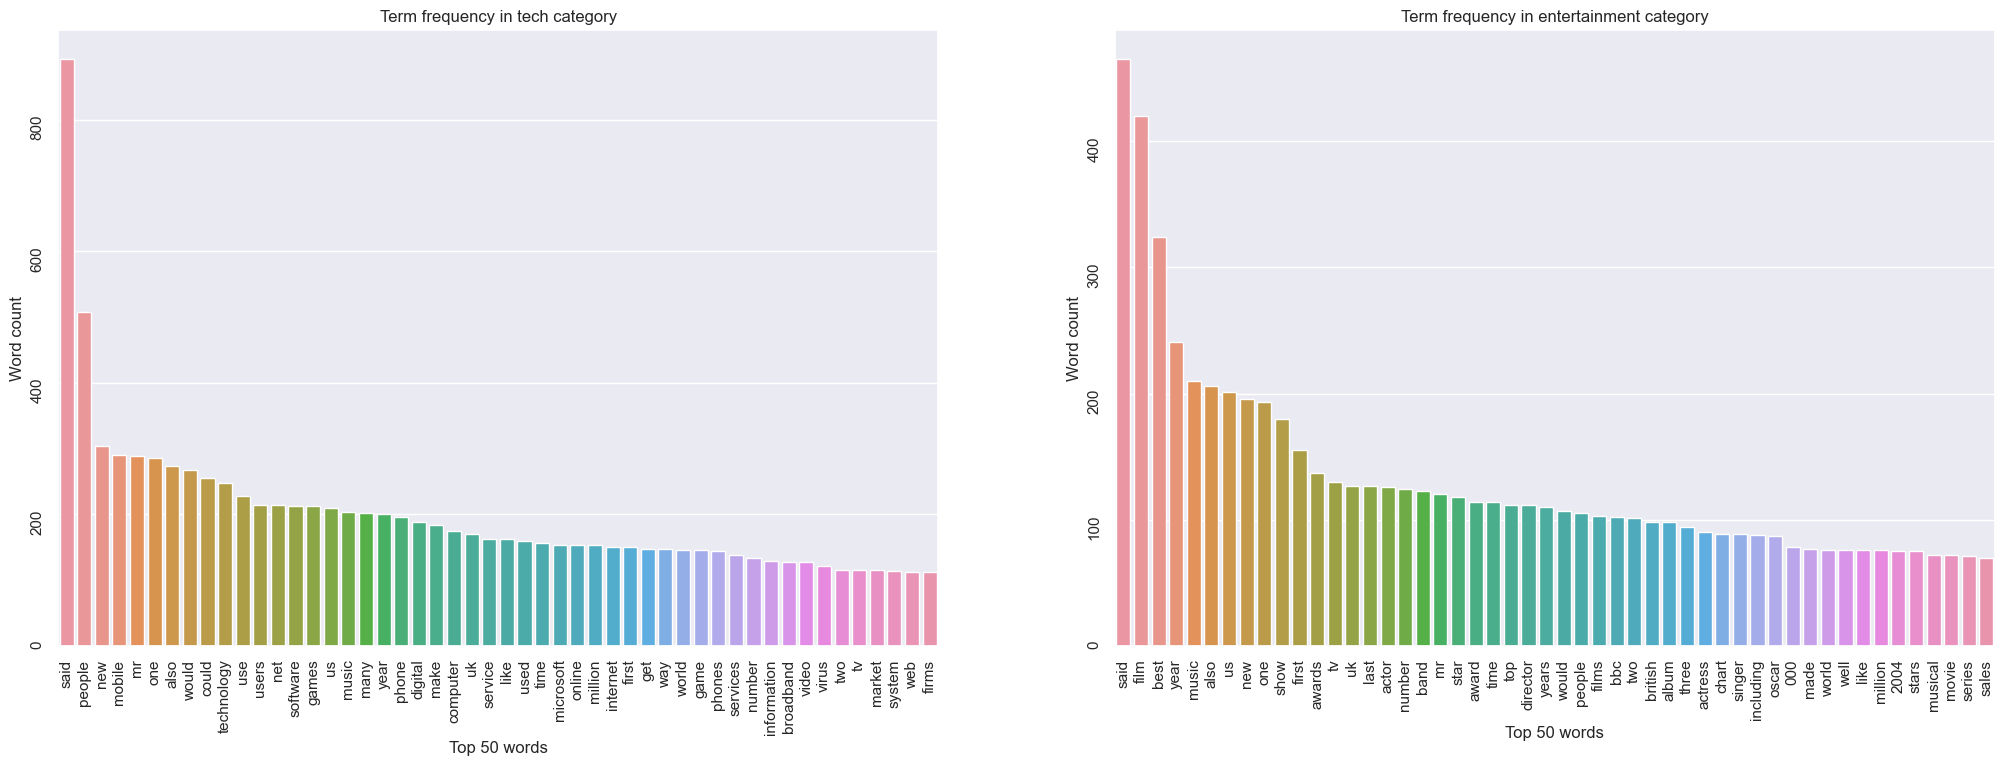

In [76]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

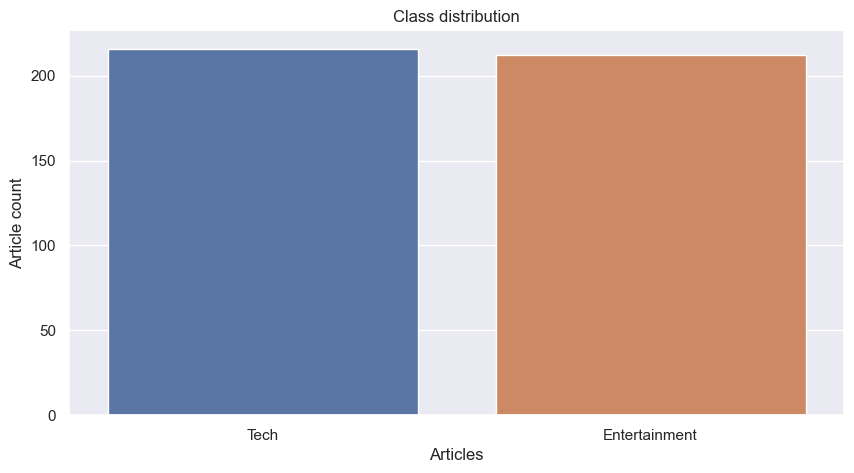

In [77]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [78]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
# summarize
# print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Neural Network

In [79]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import warnings

#warnings.filterwarnings('ignore')

#np.random.seed(1)

init_weigths = np.random.uniform(0., 0.1, 13518)
hid_units = [5,20,40]
results = []

for hid_unit in hid_units:
    clf = MLPClassifier(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.coefs_ = init_weigths

    clf.fit(prep_X_train,Y_train)

    preds = clf.predict(prep_X_test)
    score = clf.score(prep_X_test, Y_test)

    loss = log_loss(Y_test, preds)
    results.append([hid_unit, loss, score])

print(results)

[[5, 0.3400344659350677, 0.9905660377358491], [20, 0.6800689318701351, 0.9811320754716981], [40, 0.3400344659350677, 0.9905660377358491]]


[]

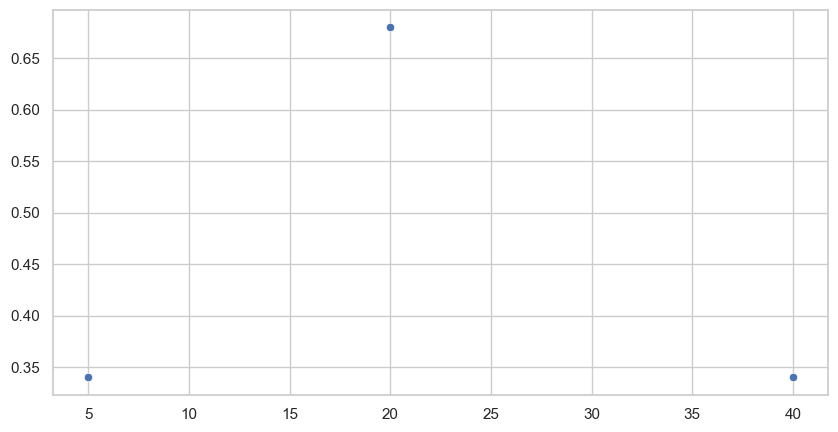

In [80]:
sns.set_style('whitegrid')
results = np.array(results).T
plot = sns.scatterplot(x=results[0], y=results[1])
plt.plot()

# Task 2C: SVM



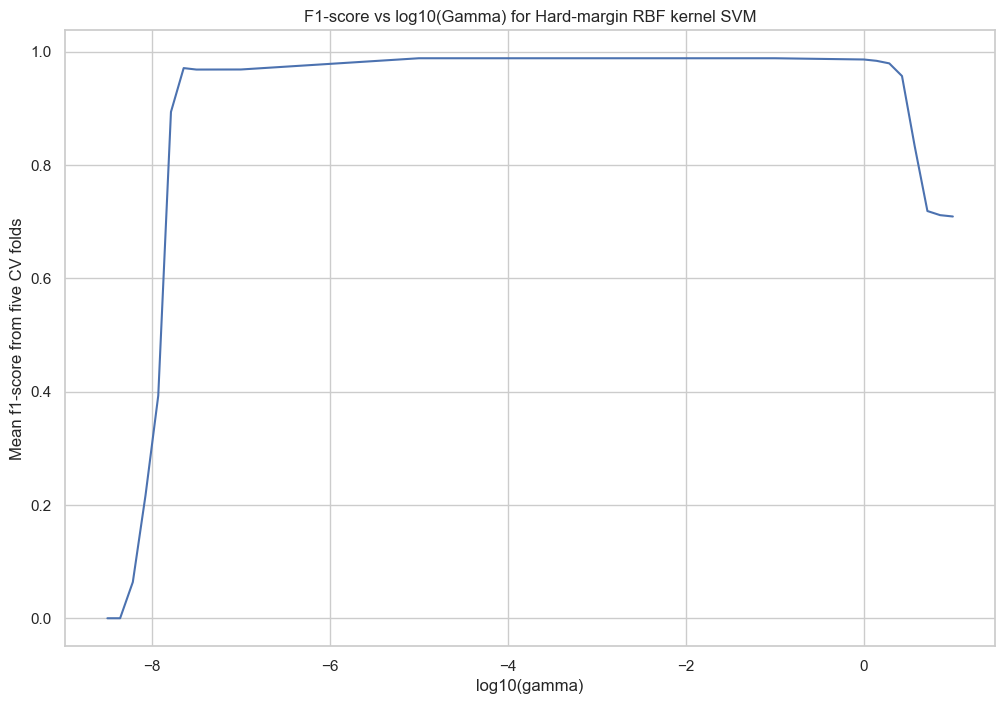

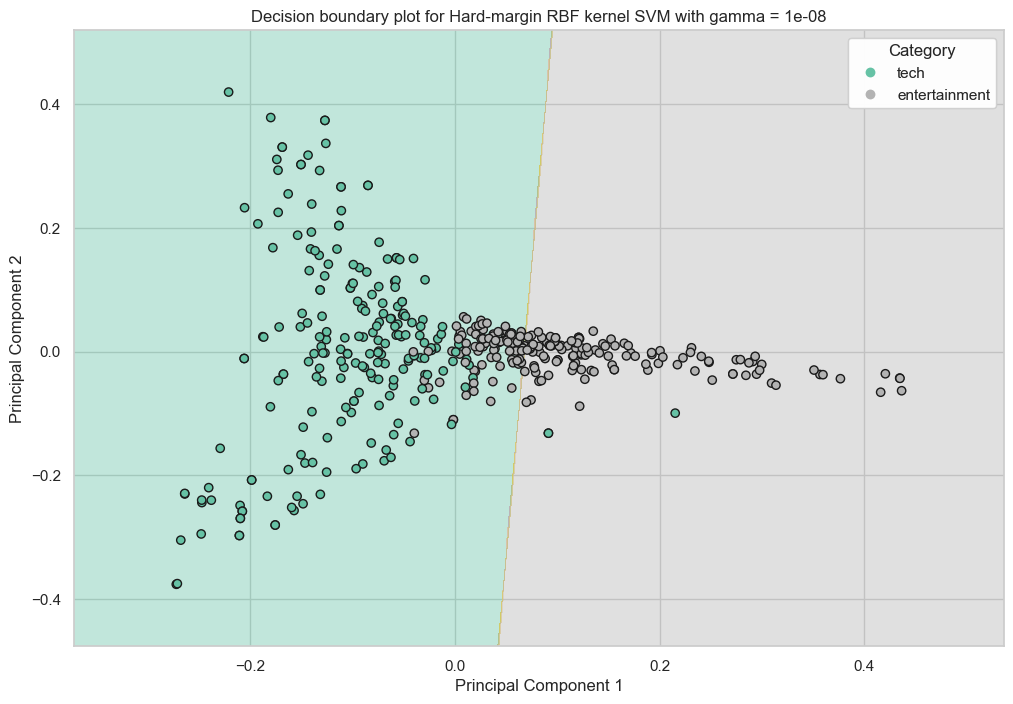

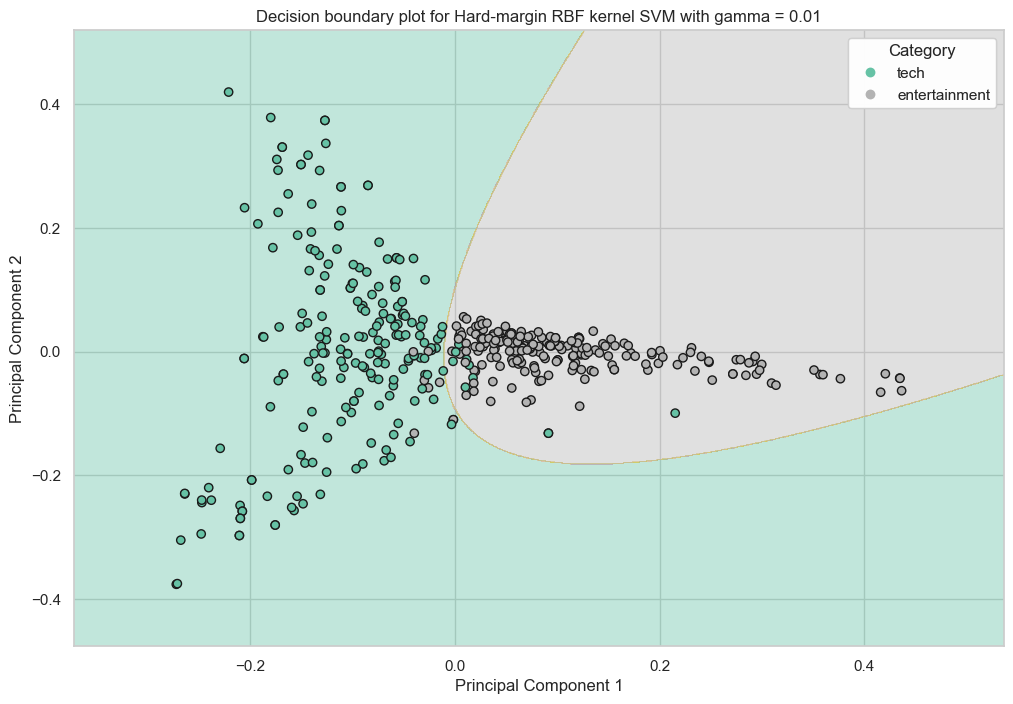

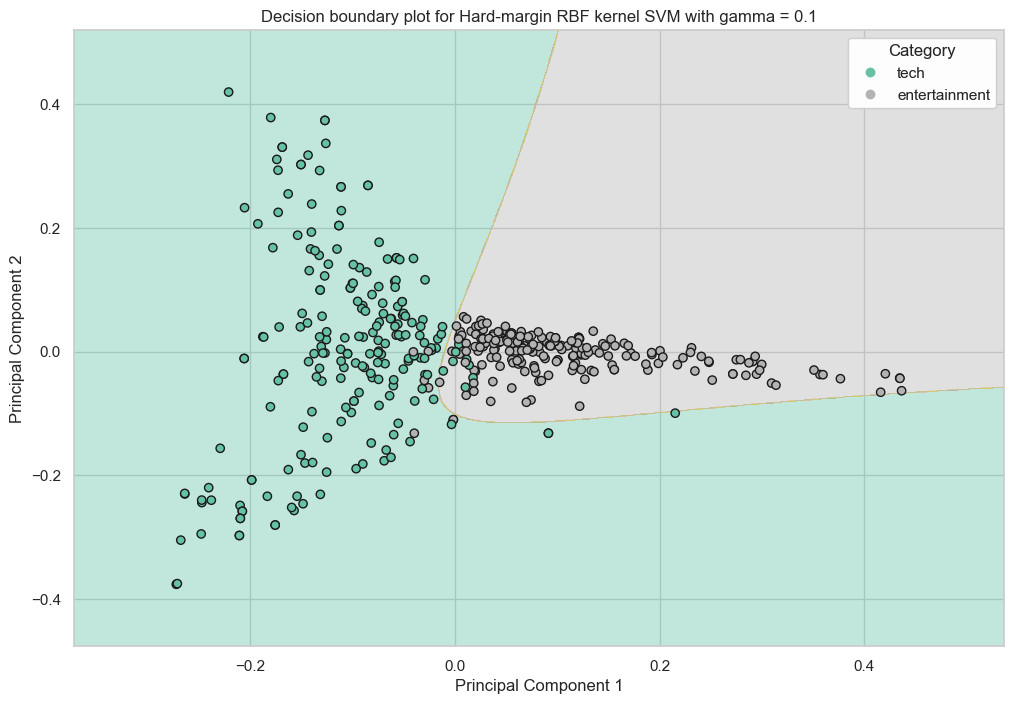

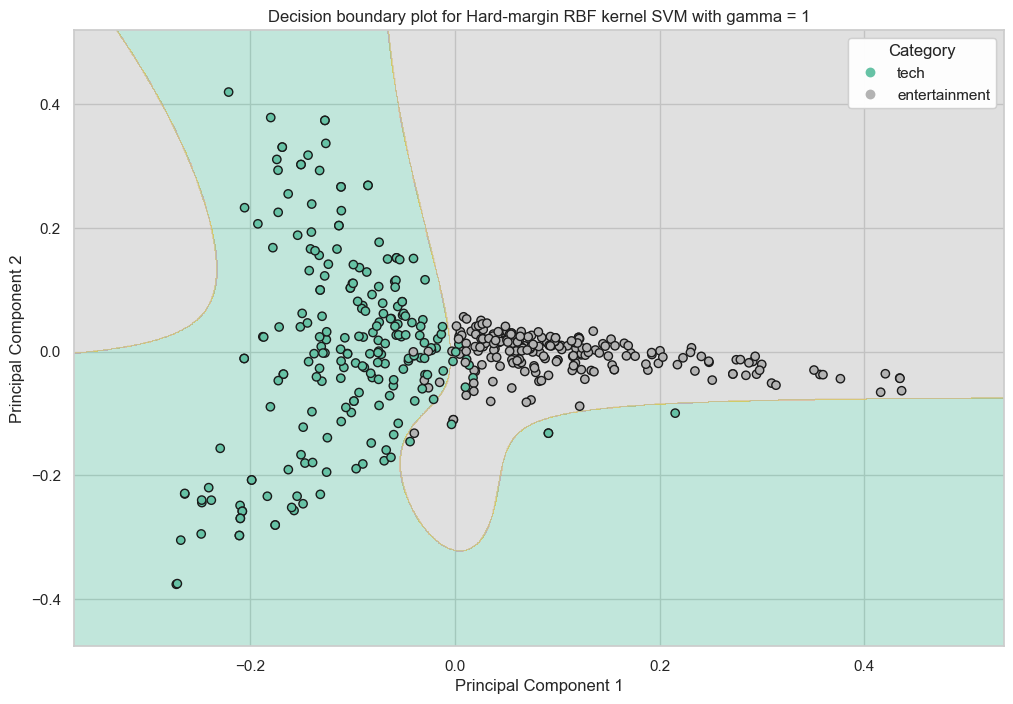

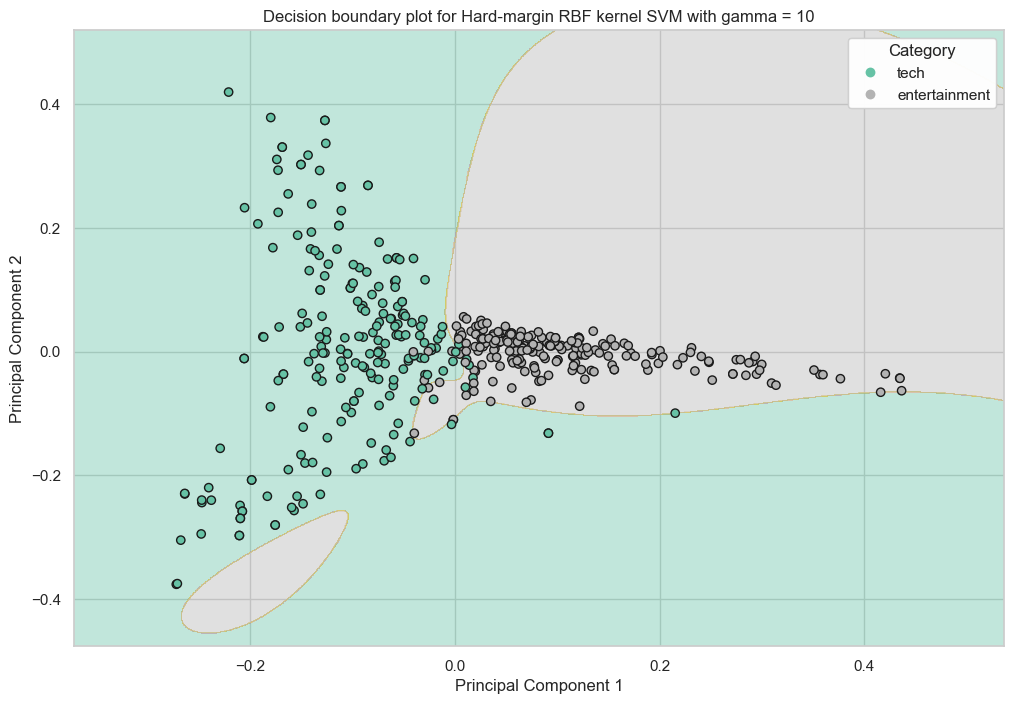

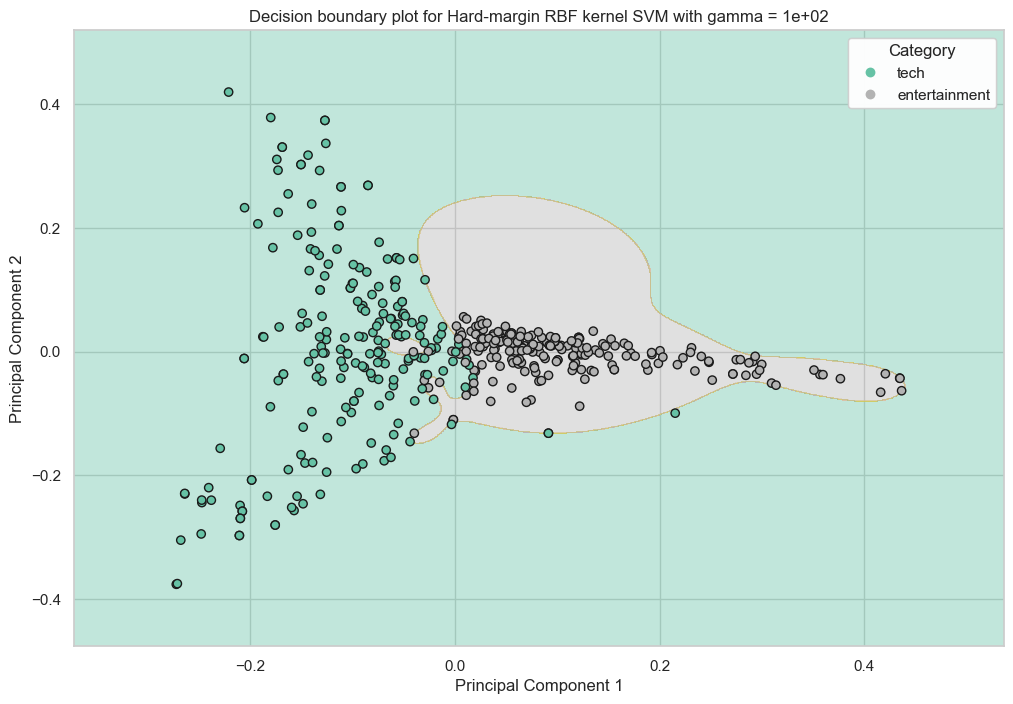

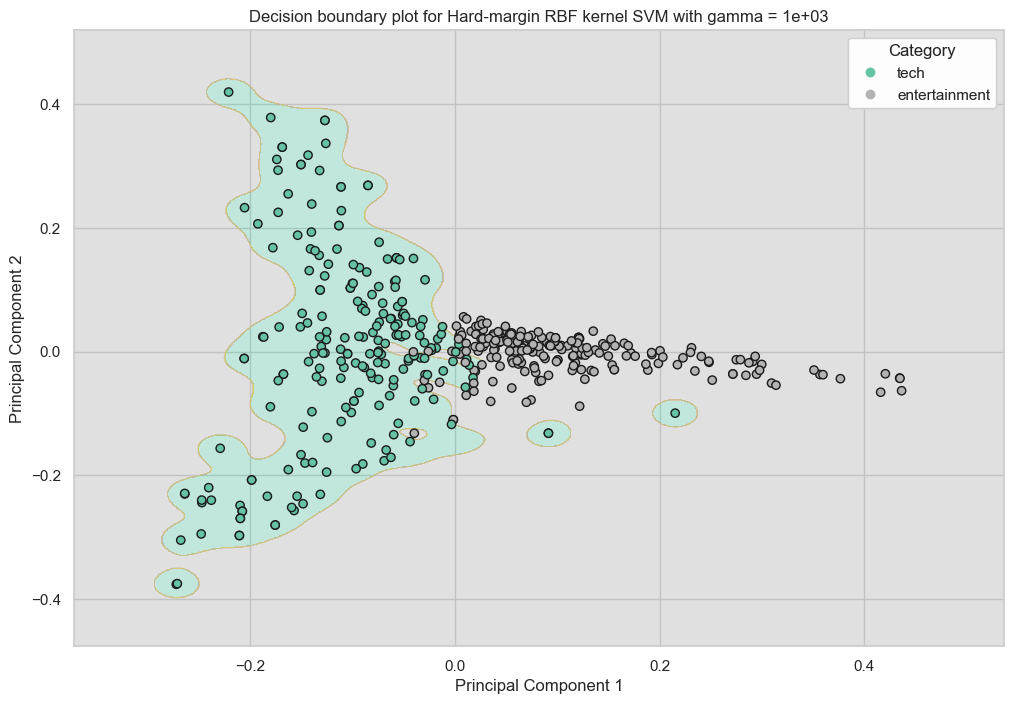

In [435]:
from sklearn import svm


np.random.seed(5)


# CV evaluating effect of gamma on f1-score performance
hyp_arr = np.empty(shape=(20,2))

grange1 = np.logspace(-8.5, -7.5, num = 8)
grange2 = np.logspace(-7, -1, num = 4)
grange3 = np.logspace(0, 1, num = 8)

count = 0

for g in grange1:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
for g in grange2:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1

for g in grange3:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
    
    
# Draw log10(Gamma) vs F1-score plot
hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(gamma)"])
hyp_ax = sns.lineplot(hyp_df, x="log10(gamma)", y="Mean f1-score from five CV folds")
hyp_ax.set_title("F1-score vs log10(Gamma) for Hard-margin RBF kernel SVM")






# Apply PCA transform, then train model and draw decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])



gvals = [10 **(-8), 10 ** (-4), 10 ** (-2), 0.1, 1, 10, 100, 1000]


for g in gvals:
    rbf_svc = svm.SVC(kernel='rbf', C=1000000000, gamma=g)

    rbf_svc.fit(pca_X_train,Y_train)

    preds = rbf_svc.predict(pca_X_test)
    score = rbf_svc.score(pca_X_test, Y_test)

    
    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12, 8)
    
    disp = DecisionBoundaryDisplay.from_estimator(rbf_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    labels = ["tech","entertainment"]
    scatterpath = ax.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    leg = ax.legend(scatterpath.legend_elements()[0], labels, loc="upper right", title="Category")
    ax.add_artist(leg)
    
    if g < 1:
        disp.ax_.set_title("Decision boundary plot of Hard-margin RBF kernel SVM with C = %0.1g" % (g))
    else:
        disp.ax_.set_title("Decision boundary plot of Hard-margin RBF kernel SVM with C = %i" % (g))
        
    plt.show()




# Task 2C Analysis: Hard-margin RBF kernel SVM

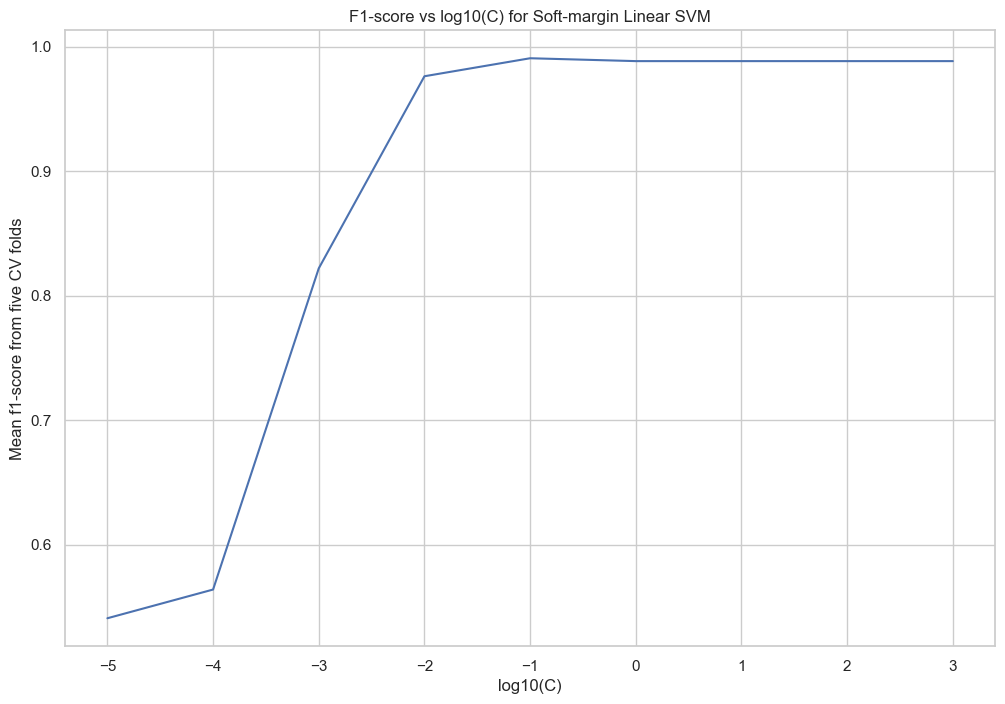

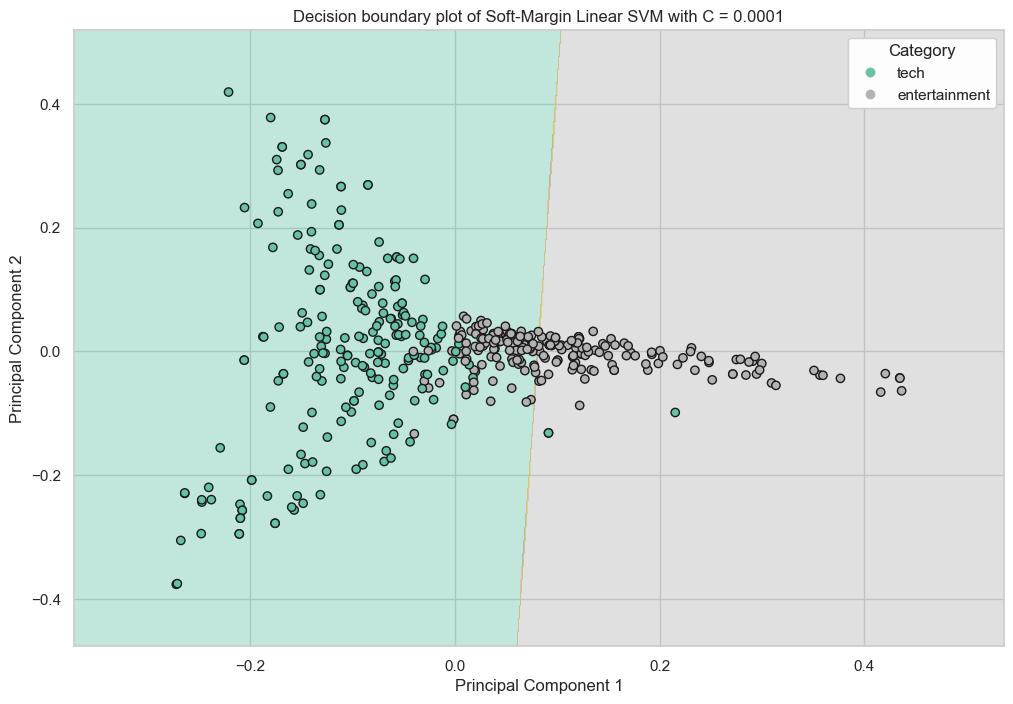

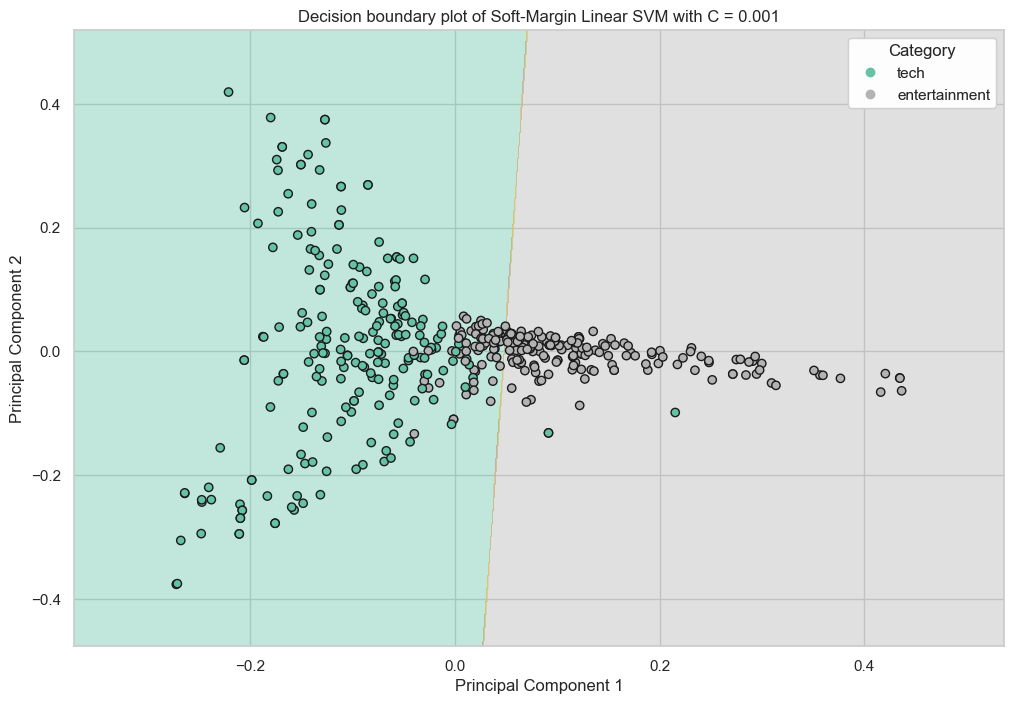

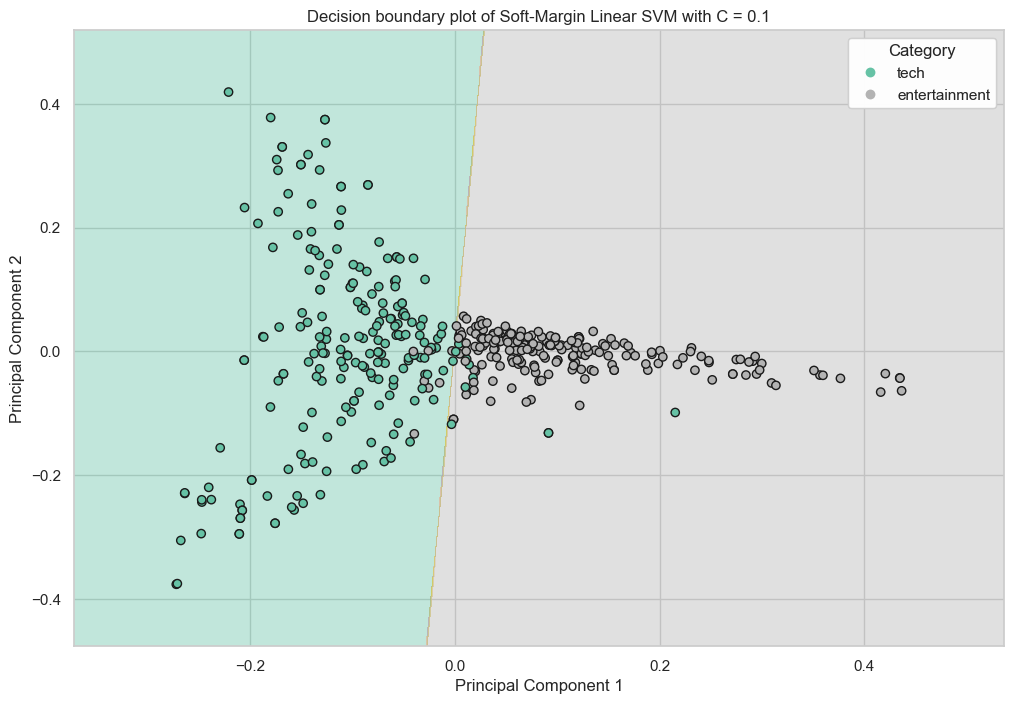

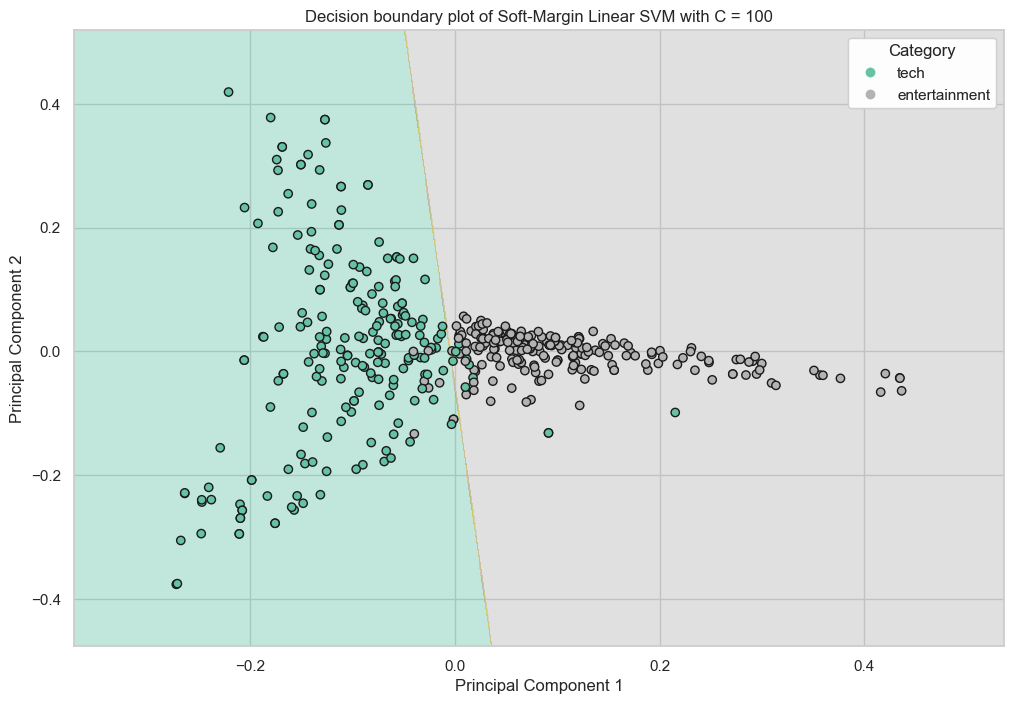

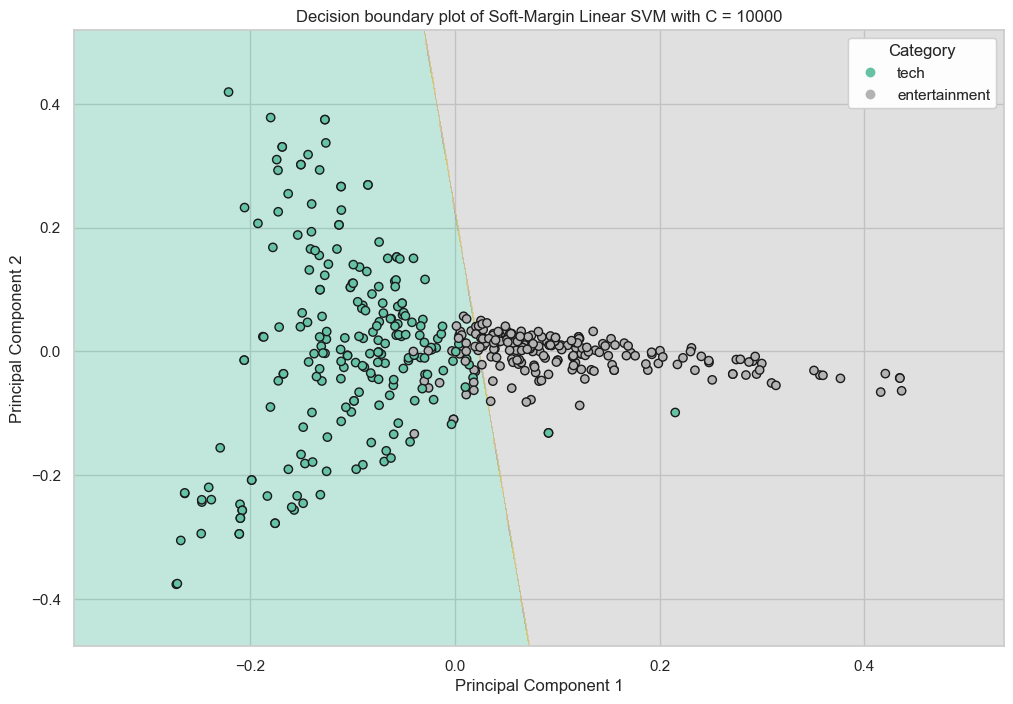

In [434]:
hyp_log = []
scores = []


# CV evaluating effect of C on f1-score performance
hyp_arr = np.empty(shape=(9,2))
crange = np.logspace(-5, 3, num = 9)

count = 0

for c in crange:
    clf = svm.LinearSVC(C=c)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(c))
    count += 1


    

# Draw log10(C) vs F1-score plot
hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(C)"])   
hyp_ax = sns.lineplot(hyp_df, x="log10(C)", y="Mean f1-score from five CV folds")
hyp_ax.set_title("F1-score vs log10(C) for Soft-margin Linear SVM")





# Apply PCA transform, then train model and draw decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])


cvals = [10**(-4), 10**(-3), 10**(-1), 10**2, 10**4]



for c in cvals:
    lin_svc = svm.LinearSVC(C=c)

    lin_svc.fit(pca_X_train,Y_train)

    preds = lin_svc.predict(pca_X_test)
    score = lin_svc.score(pca_X_test, Y_test)



    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12, 8)
    
    disp = DecisionBoundaryDisplay.from_estimator(lin_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    
    labels = ["tech","entertainment"]
    scatterpath = ax.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    leg = ax.legend(scatterpath.legend_elements()[0], labels, loc="upper right", title="Category")
    ax.add_artist(leg)
    
    if c < 1:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %0.1g" % (c))
    else:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %i" % (c))
        
    plt.show()


# Task 2C Analysis: Soft-margin Linear SVM

# Task 3A: SVM

We aim to show the effect of training set size on the performance of SVMs.

We use two models to demonstrate this effect:
 - Soft-margin Linear SVM. C = -1.0
 - Hard-margin RBF kernel SVM. Gamma = 0.1
 
The hyperparameters are chosen from the preliminary analysis in Task 2C. These values were shown to yield a high cross-validation accuracy.

In [ ]:
percents = [0.1, 0.3, 0.5, 0.7, 0.9]
acc_arr = np.empty(shape=(len(percents),2))

for i in range(len(percents)):
    m = percents[i]
    n = math.ceil(len(prep_X_train.index) * m)
    
    clf = svm.SVC(kernel="rbf", C = 100000000000000000, gamma = 0.00000000000001)
    clf.fit(prep_X_train.iloc[0: n], Y_train.iloc[0: n])
    
    train_preds = clf.predict(prep_X_train.iloc[0: n])
    test_preds = clf.predict(prep_X_test)
    
    train_f1 = f1_score(Y_train.iloc[0: n], train_preds)
    test_f1 = f1_score(Y_test, test_preds)
    
    acc_arr[i] = (train_f1, test_f1)

print(acc_arr)

# Task 3A Analysis

# Task 3B: SVM

Now we find the best kernel and hyperparameters for the SVM. For the measure of performance, we take the mean f1-score across 5 cross validation folds.


We test four kernels: Linear, RBF, Polynomial, and Sigmoid.

All kernels have the soft-margin hyperparameter C.

RBF, Polynomial, and Sigmoid also have a gamma hyperparameter.

Polynomial has an additional hyperparameter, d, which determines the degree of the polynomial.

We use GridSearchCV to find the best combination of hyperparameters for each kernel.




In [ ]:
# For each kernel, we find the best combination of hyperparameter settings.
cvals = np.logspace(-4, 2, 10)
pgrid = { "C" : cvals }

svc = svm.SVC(kernel="linear")
lin_cv = GridSearchCV(svc, pgrid, scoring="f1")
lin_cv.fit(prep_X_train, Y_train)




gvals = np.logspace(-5, 1, 10)
pgrid["gamma"] = gvals

svc = svm.SVC(kernel="rbf")
rbf_cv = GridSearchCV(svc, pgrid, scoring="f1")
rbf_cv.fit(prep_X_train, Y_train)


svc = svm.SVC(kernel="sigmoid")
sig_cv = GridSearchCV(svc, pgrid, scoring="f1")
sig_cv.fit(prep_X_train, Y_train)




dvals = [1, 2, 3, 4]
pgrid["degree"] = dvals

svc = svm.SVC(kernel="poly")
pol_cv = GridSearchCV(svc, pgrid, scoring="f1")
pol_cv.fit(prep_X_train, Y_train)


In [444]:
from sklearn.metrics import f1_score


# For each kernel, find the best-performing hyperparameter combinations. Find the f1-score of each model
# on the test set and the training set.
lin_cv.cv_results_
print("Best hyperparameters for the Linear SVM are:")
print("C = %0.5g" % lin_cv.best_params_["C"])
print("Test set f1-score of tuned Linear SVM is %0.4f." % (lin_cv.score(prep_X_test, Y_test)))
      
train_preds = lin_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned Linear SVM is %0.4f.\n" % (train_score))




rbf_cv.cv_results_
print("Best hyperparameters for the RBF SVM are:")
print("C = %0.5g" % rbf_cv.best_params_["C"])
print("Gamma = %0.5g" % rbf_cv.best_params_["gamma"])
print("Test set f1-score of tuned RBF SVM is %0.4f." % (rbf_cv.score(prep_X_test, Y_test)))
      
train_preds = rbf_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned RBF SVM is %0.4f.\n" % (train_score))




sig_cv.cv_results_
print("Best hyperparameters for the Sigmoid SVM are:")
print("C = %0.5g" % sig_cv.best_params_["C"])
print("Gamma = %0.5g" % sig_cv.best_params_["gamma"])
print("Test set f1-score of tuned Sigmoid SVM is %0.4f." % (sig_cv.score(prep_X_test, Y_test)))

train_preds = sig_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned Sigmoid SVM is %0.4f.\n" % (train_score))




pol_cv.cv_results_
print("Best hyperparameters for the Polynomial SVM are:")
print("C = %0.5g" % pol_cv.best_params_["C"])
print("Gamma = %0.5g" % pol_cv.best_params_["gamma"])
print("Degree = %i" % pol_cv.best_params_["degree"])
print("Test set f1-score of tuned Polynomial SVM is %0.4f." % (pol_cv.score(prep_X_test, Y_test)))

train_preds = pol_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned Polynomial SVM is %0.4f.\n" % (train_score))






Best hyperparameters for the Linear SVM are:
C = 0.39811
Test set f1-score of tuned Linear SVM is 1.0000.
Training set f1-score of tuned Linear SVM is 0.9976.

Best hyperparameters for the RBF SVM are:
C = 6.3096
Gamma = 0.063096
Test set f1-score of tuned RBF SVM is 0.9917.
Training set f1-score of tuned RBF SVM is 0.9976.

Best hyperparameters for the Sigmoid SVM are:
C = 6.3096
Gamma = 0.063096
Test set f1-score of tuned Sigmoid SVM is 1.0000.
Training set f1-score of tuned Sigmoid SVM is 0.9976.

Best hyperparameters for the Polynomial SVM are:
C = 0.39811
Gamma = 1
Degree = 2
Test set f1-score of tuned Polynomial SVM is 0.9919.
Training set f1-score of tuned Polynomial SVM is 0.9976.

[[1.         0.93913043]
 [0.98484848 0.93913043]
 [0.98550725 0.9009009 ]
 [0.98601399 0.88073394]
 [0.95675676 0.87037037]]


 # Task 3B Analysis